# Demo of SCOD with a simple 2D dataset

In [1]:
%load_ext autoreload
%autoreload 2

import scod
import torch
import numpy as np
from tqdm import trange

import seaborn as sns
from matplotlib import pyplot as plt

First, define the dataset

In [56]:
class TwoDDataset(torch.utils.data.Dataset):
    def __init__(self, N=100, fn=(lambda x: np.sin(2*x) ), split='train') -> None:
        super().__init__()
        if split == 'train':
            np.random.seed(1001)
        elif split == 'val':
            np.random.seed(2001)
        else:
            np.random.seed(3001)
        x1 = np.concatenate([-1.5 + np.random.rand(N//2), 0.5 + np.random.rand(N - N//2)])
        x2 = -1 + 2*np.random.rand(N)
        x = np.stack([x1,x2],axis=-1)
        y = fn(x.sum(-1))
        self.X = torch.from_numpy(x).float()
        self.Y = torch.from_numpy(y).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx,None])

class UniformDataset(torch.utils.data.Dataset):
    def __init__(self, N=500) -> None:
        super().__init__()

        x = -3 + 6*np.random.rand(N*2).reshape([N,2])
        y = x[:,0]
        self.X = torch.from_numpy(x).float()
        self.Y = torch.from_numpy(y).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx,None])


Next, we create a model (simple MLP), and train it to fit this data

In [57]:
# DNN mapping 2d input to 1d distribution parameter
relu_model = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1)
)

# here, we interpret the output of the DNN as the mean of a Gaussian
dist_constructor = lambda theta: scod.distributions.Normal(loc=theta, scale=0.05)

In [58]:
tanh_model = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 64),
    torch.nn.Tanh(),
    torch.nn.Linear(64, 1)
)

### train a base DNN model

mean_loss=-1.862370: 100%|██████████| 50/50 [00:00<00:00, 100.32it/s]


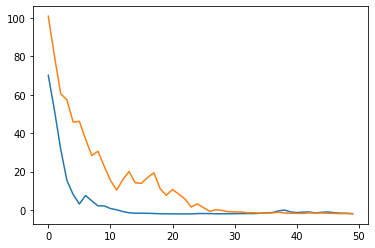

In [59]:
for model in [relu_model, tanh_model]:
    dataset = TwoDDataset()
    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    losses = []
    t = trange(50)

    for epoch in t:
        epoch_loss = 0.
        for (inputs, targets) in train_dataloader:
            optimizer.zero_grad()
            
            outputs = model(inputs)
            dist = dist_constructor(outputs)
            loss = -dist.log_prob(targets)

            mean_loss = loss.mean()

            mean_loss.backward()

            epoch_loss += mean_loss
            
            optimizer.step()
            
        epoch_loss /= len(train_dataloader)
        
        t.set_description("mean_loss=%02f"%epoch_loss.item())
        losses.append(epoch_loss.item())

    plt.plot(losses)

Visualize the simple trained DNN

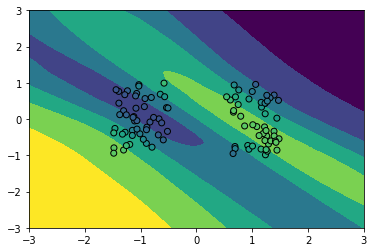

In [60]:
X1,X2 = np.meshgrid( np.linspace(-3.,3.,50), np.linspace(-3.,3.,50) )
X = np.stack([X1,X2], axis=-1)
xx_tensor = torch.from_numpy(X).view(-1,2).float()
yhat = relu_model(xx_tensor)
yhat = yhat[:,0].detach().cpu().numpy()

plt.contourf(X1,X2,yhat.reshape(X1.shape), levels=10, vmin=-2., vmax=2.)
plt.scatter(dataset.X[:,0], dataset.X[:,1], c=dataset.Y, vmin=-2, vmax=2, edgecolors='k')

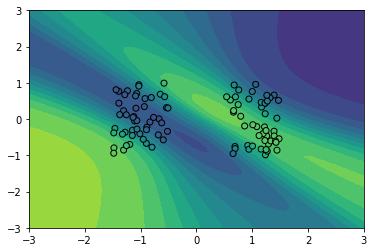

In [61]:
X1,X2 = np.meshgrid( np.linspace(-3.,3.,50), np.linspace(-3.,3.,50) )
X = np.stack([X1,X2], axis=-1)
xx_tensor = torch.from_numpy(X).view(-1,2).float()
yhat = tanh_model(xx_tensor)
yhat = yhat[:,0].detach().cpu().numpy()

plt.contourf(X1,X2,yhat.reshape(X1.shape), levels=10, vmin=-2., vmax=2.)
plt.scatter(dataset.X[:,0], dataset.X[:,1], c=dataset.Y, vmin=-2, vmax=2, edgecolors='k')

### Applying SCOD
Now, we apply SCOD to the network to add uncertainty estimation

In [62]:
unc_model = scod.SCOD(tanh_model, dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
})

Weight space dimension: 8.577e+03


### process training dataset to compute posterior uncertainty

In [63]:
unc_model.process_dataset(dataset)

computing basis
using T = 304


  0%|          | 0/100 [00:00<?, ?it/s]

Estimating alpha


  0%|          | 0/100 [00:00<?, ?it/s]

-536380.1875


In [64]:
relu_unc_model = scod.SCOD(relu_model, dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304,
    'sketch_type': 'srft',
})

relu_unc_model.process_dataset(dataset)


Weight space dimension: 8.577e+03
computing basis
using T = 304


  0%|          | 0/100 [00:00<?, ?it/s]

Estimating alpha


  0%|          | 0/100 [00:00<?, ?it/s]

24298754.0


### compare SCOD's predictions to the original trained model

In [65]:
settings = [
    {   
        'name': 'Tanh Activations',
        'model': unc_model,
        'prior_scales': None,
    },
    {   
        'name': 'ReLU Activations',
        'model': relu_unc_model,
        'prior_scales': None,
    },
]

In [66]:
X1,X2 = np.meshgrid( np.linspace(-3.,3.,50), np.linspace(-3.,3.,50) )
X = np.stack([X1,X2], axis=-1)
xx_tensor = torch.from_numpy(X).view(-1,2).float()
yhat = model(xx_tensor)
yhat = yhat[:,0].detach().cpu().numpy()

In [67]:
results = []
for setting in settings:
    print(setting)
    scod_model = setting['model']
    scod_model.alpha *= 0
    old_prior_scales = scod_model.log_prior_scale.data + 0.
    if setting['prior_scales'] is not None:
        scod_model.log_prior_scale.data = setting['prior_scales']
    
    dists, _ = scod_model(xx_tensor)
    prior_dists, _ = scod_model(xx_tensor, use_prior=True)

    scod_model.log_prior_scale.data = old_prior_scales
    vars = np.array( [torch.sqrt(dist.variance).sum().detach().cpu() for dist in dists] )
    prior_vars = np.array( [torch.sqrt(dist.variance).sum().detach().cpu() for dist in prior_dists] )
    result = {
        'name': setting['name'],
        'vars': vars.reshape(X1.shape),
        'prior_vars': prior_vars.reshape(X1.shape)
    }
    results.append(result)

{'name': 'Tanh Activations', 'model': SCOD(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
), 'prior_scales': None}
{'name': 'ReLU Activations', 'model': SCOD(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
), 'prior_scales': None}


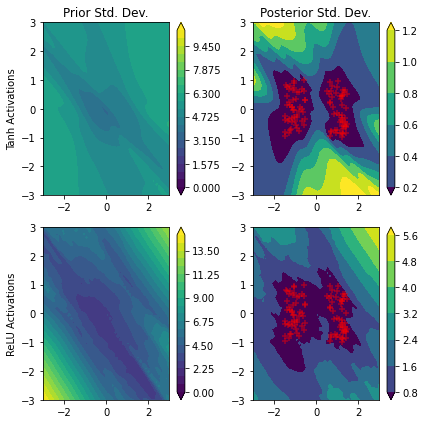

In [71]:
fig, axes = plt.subplots(len(results), 2, figsize=[6,6])
for i, result in enumerate(results):
    max_unc = max(np.round(np.quantile(result['prior_vars'], 0.9) /0.9 )*1.5, 1.)
    levels = np.linspace(0., max_unc, 21)
    m = axes[i,0].contourf(X1,X2,result['prior_vars'], vmin=0., vmax=max_unc, extend='both', levels=levels)
    plt.colorbar(m, ax=axes[i,0])
    m.set_clim([0, m.get_clim()[1]])
    
    m = axes[i,1].contourf(X1,X2,result['vars'], vmin=0., extend='both')
    plt.colorbar(m, ax=axes[i,1])
    m.set_clim([0, m.get_clim()[1]])
    axes[i,1].scatter(dataset.X[:,0], dataset.X[:,1], marker='+', vmin=-2, vmax=2, color='red', alpha=0.5)

    axes[i,0].set_ylabel(result['name'])

axes[0,0].set_title('Prior Std. Dev.')
axes[0,1].set_title('Posterior Std. Dev.')

plt.tight_layout()
plt.savefig("qualitative_2d.pdf")

Text(0.5, 1.0, 'Distribution of per-weight prior variances')

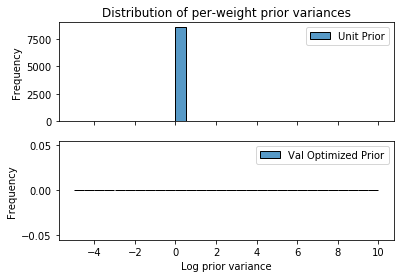

In [20]:
fig, axes = plt.subplots(len(settings),1, sharex=True)

for ax, setting in zip(axes, settings):
    log_prior_scale = setting['model'].log_prior_scale.detach().cpu()
    if setting['prior_scales'] is not None:
        log_prior_scale = setting['prior_scales'].detach().cpu()
    sns.histplot(setting['model']._broadcast_to_n_weights(log_prior_scale), ax=ax, label=setting['name'], binrange=[-5,10], binwidth=0.5)
    ax.legend()
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Log prior variance')

axes[0].set_title('Distribution of per-weight prior variances')
